
# **Avance 4 – Modelos Alternativos**  
**Proyecto:** Proyecto Integrador

**Equipo 41**

**Integrantes:**
- Benitez Ortega, Luis Ángel — A01795165
- Del Valle Azuara, Claudio Luis — A01795773
- Islas Blanco, Alejandra — A01794452

**Institución:** Tecnológico de Monterrey

---

## Objetivo de la entrega
1. Entrenar **≥6 modelos** de clasificación bajo un **esquema de validación homogéneo**.  
2. Evaluar con **≥3 métricas** y registrar **tiempos de entrenamiento**.  
3. Seleccionar los **2 mejores modelos**, realizar **ajuste fino de hiperparámetros** y **comparar en test**.  
4. **Elegir un modelo final** y justificarlo con base en rendimiento, estabilidad, interpretabilidad y costo computacional.



## 1) Configuración, reproducibilidad y utilidades

- Se fijan semillas para reproducibilidad.
- Se definen utilidades de cronometraje y formateo de tablas.
- Se cargan dependencias estándar de *scikit-learn*.


In [2]:

import os, sys, time, json, math, warnings, itertools
from pathlib import Path
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Silenciar warnings no críticos
warnings.filterwarnings("ignore")

# Pretty print helpers
def fmt(v, nd=4):
    try:
        return f"{v:.{nd}f}"
    except Exception:
        return str(v)

def title(msg):
    print("\n" + "="*len(msg))
    print(msg)
    print("="*len(msg))

# Cronómetro simple
class Stopwatch:
    def __init__(self): self.t0 = None
    def start(self): self.t0 = time.perf_counter()
    def stop(self): return time.perf_counter() - self.t0 if self.t0 else None


## 2) Carga de datos

In [5]:
from pathlib import Path
import pandas as pd

DATA_DIR = Path('.').resolve()

def try_read(path_stem: str):
    csv  = DATA_DIR / f"{path_stem}.csv"
    if csv.exists():
        return pd.read_csv(csv)
    raise FileNotFoundError(f"No se encontró {path_stem}.csv en {DATA_DIR}")

# Cargamos engineered_features
df = try_read('engineered_features')

# Cargar generated_converted si quieres referenciar campos originales
try:
    df_raw = try_read('generated_converted')
except FileNotFoundError:
    df_raw = None

TARGET_COL = 'final_label'
assert TARGET_COL in df.columns, f"No se encuentra la columna objetivo '{TARGET_COL}' en engineered_features."

# X/y desde engineered_features
y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

# Split estratificado
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

title('Resumen de los datos')
print('Ruta de datos:', DATA_DIR)
print('df:', df.shape, '| X_train:', X_train.shape, '| X_test:', X_test.shape)
print('Distribución y_train:')



Resumen de los datos
Ruta de datos: C:\Users\Admin\Downloads\Avance 4
df: (161, 302) | X_train: (128, 301) | X_test: (33, 301)
Distribución y_train:



## 3) Preprocesamiento


In [7]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# En engineered_features todas las columnas de X son numéricas
num_cols = list(X_train.columns)

preprocess = ColumnTransformer([
    ("num", StandardScaler(with_mean=False), num_cols),
], remainder="drop")

print("Numéricas:", len(num_cols))


Numéricas: 301



## 4) Esquema de validación y métricas

- **Validación:** `StratifiedKFold(n_splits=5, shuffle=True, random_state=42)`  
- **Métrica principal:** `f1_macro`
- **Métricas adicionales:** `accuracy`, `precision_macro`, `recall_macro`.  
- **Registro de tiempo:** medimos el tiempo total de `cross_validate` (incluye `fit` y `score`).


In [8]:

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline

SCORING = ["f1_macro", "accuracy", "precision_macro", "recall_macro"]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def eval_model(name, estimator, X, y, scoring=SCORING):
    pipe = Pipeline([("prep", preprocess), ("clf", estimator)])
    sw = Stopwatch(); sw.start()
    cv = cross_validate(pipe, X, y, cv=skf, scoring=scoring, n_jobs=-1, return_train_score=False)
    elapsed = sw.stop()
    row = {"model": name, "cv_time_s": elapsed}
    for m in scoring:
        row[f"{m}_mean"] = float(np.mean(cv[f"test_{m}"]))
        row[f"{m}_std"]  = float(np.std(cv[f"test_{m}"]))
    return row



## 5) Modelos candidatos


In [9]:

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

candidatos = {
    "logreg": LogisticRegression(max_iter=1000),
    "linsvc": LinearSVC(),
    "svc_rbf": SVC(probability=True),
    "rf": RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE),
    "hgb": HistGradientBoostingClassifier(random_state=RANDOM_STATE),
    "knn": KNeighborsClassifier(),
    "nb": GaussianNB(),
    "dt": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "mlp": MLPClassifier(hidden_layer_sizes=(128,), max_iter=300, random_state=RANDOM_STATE)
}

results = []
for name, est in candidatos.items():
    try:
        row = eval_model(name, est, X_train, y_train, scoring=SCORING)
        results.append(row)
        print(f"{name}: f1_macro={fmt(row['f1_macro_mean'])} ± {fmt(row['f1_macro_std'])} | time={fmt(row['cv_time_s'])}s")
    except Exception as e:
        print(f"[WARN] {name} falló: {e}")

df_cv = pd.DataFrame(results).sort_values(by="f1_macro_mean", ascending=False).reset_index(drop=True)
df_cv


logreg: f1_macro=0.8397 ± 0.0565 | time=2.4666s
linsvc: f1_macro=0.8205 ± 0.0580 | time=1.7043s
svc_rbf: f1_macro=0.7224 ± 0.0654 | time=1.6989s
rf: f1_macro=0.8101 ± 0.0528 | time=2.1780s
hgb: f1_macro=0.8104 ± 0.0634 | time=1.3438s
knn: f1_macro=0.4418 ± 0.0938 | time=0.1909s
nb: f1_macro=0.7645 ± 0.0245 | time=0.0466s
dt: f1_macro=0.7702 ± 0.1159 | time=0.0624s
mlp: f1_macro=0.5835 ± 0.1365 | time=0.2208s


,model,cv_time_s,f1_macro_mean,f1_macro_std,accuracy_mean,accuracy_std,precision_macro_mean,precision_macro_std,recall_macro_mean,recall_macro_std
0,logreg,2.466638,0.839711,0.056495,0.866769,0.041345,0.864664,0.055513,0.834921,0.050545
1,linsvc,1.704288,0.820464,0.057979,0.850769,0.048063,0.833848,0.056664,0.822222,0.056422
2,hgb,1.343764,0.810441,0.063371,0.844000,0.053803,0.832094,0.068059,0.812698,0.060202
3,rf,2.178011,0.810062,0.052788,0.851077,0.039910,0.841352,0.055461,0.814286,0.049589
4,dt,0.062448,0.770162,0.115936,0.813538,0.088722,0.779453,0.117421,0.773810,0.110143
5,nb,0.046625,0.764546,0.024461,0.812308,0.017269,0.789188,0.038901,0.770635,0.021355
6,svc_rbf,1.698889,0.722358,0.065406,0.781231,0.039264,0.772293,0.075869,0.725397,0.048040
7,mlp,0.220830,0.583478,0.136525,0.664308,0.100330,0.603492,0.175148,0.591270,0.115066
8,knn,0.190946,0.441772,0.093806,0.585846,0.057781,0.571837,0.179498,0.477778,0.072809



## 6) Comparativa visual de desempeño


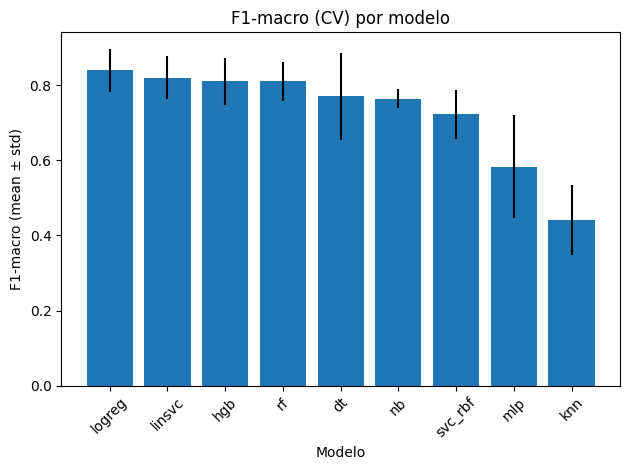

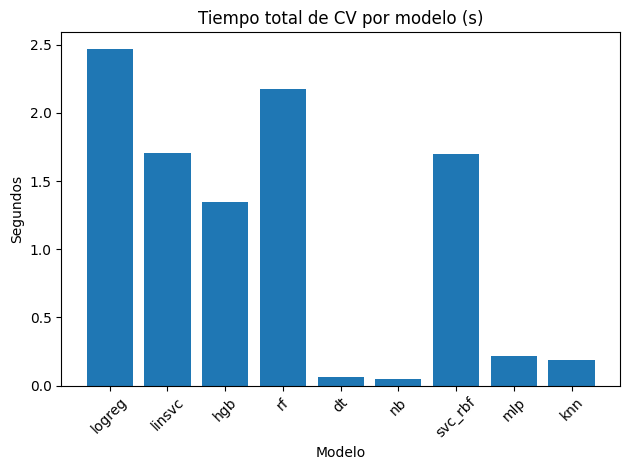

In [10]:

plt.figure()
plt.bar(df_cv["model"], df_cv["f1_macro_mean"], yerr=df_cv["f1_macro_std"])
plt.title("F1-macro (CV) por modelo")
plt.xlabel("Modelo")
plt.ylabel("F1-macro (mean ± std)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(df_cv["model"], df_cv["cv_time_s"])
plt.title("Tiempo total de CV por modelo (s)")
plt.xlabel("Modelo")
plt.ylabel("Segundos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## 7) Selección de Top-2 y ajuste fino

Seleccionamos los **2 mejores** por la métrica principal (`f1_macro_mean`). En caso de empate, considerar `accuracy` o **tiempo**.


In [12]:

top2 = df_cv.head(2)["model"].tolist()
print("Top-2:", top2)

from sklearn.model_selection import GridSearchCV
grids = {
    "logreg": {
        "clf__C": [0.1, 1.0, 3.0, 10.0],
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs", "liblinear"]
    },
    "linsvc": {
        "clf__C": [0.1, 1.0, 3.0, 10.0]
    },
    "svc_rbf": {
        "clf__C": [0.5, 1, 3, 10],
        "clf__gamma": ["scale", 0.1, 0.01]
    },
    "rf": {
        "clf__n_estimators": [300, 600],
        "clf__max_depth": [None, 10, 20, 40],
        "clf__min_samples_split": [2, 5]
    },
    "hgb": {
        "clf__learning_rate": [0.03, 0.06, 0.1],
        "clf__max_depth": [None, 6, 10],
        "clf__l2_regularization": [0.0, 0.1, 1.0]
    },
    "knn": {
        "clf__n_neighbors": [3, 5, 9, 15],
        "clf__weights": ["uniform", "distance"]
    },
    "mlp": {
        "clf__hidden_layer_sizes": [(64,), (128,), (64,32)],
        "clf__alpha": [1e-4, 1e-3, 1e-2]
    },
    "dt": {
        "clf__max_depth": [None, 6, 12, 20],
        "clf__min_samples_split": [2, 5, 10]
    },
    "nb": {
        "clf__var_smoothing": [1e-9, 1e-8, 1e-7]
    }
}

def tune_model(model_name):
    est = candidatos[model_name]
    pipe = Pipeline([("prep", preprocess), ("clf", est)])
    grid = grids.get(model_name, {})
    gs = GridSearchCV(
        pipe, grid, scoring="f1_macro", cv=skf, n_jobs=-1, verbose=1
    )
    gs.fit(X_train, y_train)
    return gs


Top-2: ['logreg', 'linsvc']



## 8) Entrenamiento con mejor set de hiperparámetros y evaluación en **test**

Reportamos: F1-macro, Accuracy, Precision-macro y Recall-macro



Ajuste fino: logreg
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Mejores parámetros: {'clf__C': 3.0, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Mejor score CV (f1_macro): 0.8492

Classification report (test):
               precision    recall  f1-score   support

     clarify       1.00      0.89      0.94         9
    continue       1.00      1.00      1.00        15
     handoff       0.90      1.00      0.95         9

    accuracy                           0.97        33
   macro avg       0.97      0.96      0.96        33
weighted avg       0.97      0.97      0.97        33



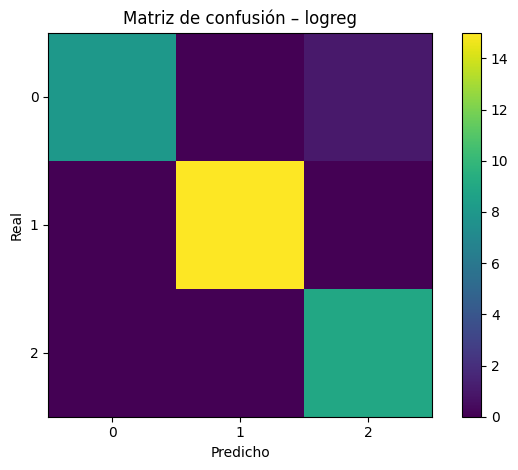


Ajuste fino: linsvc
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejores parámetros: {'clf__C': 0.1}
Mejor score CV (f1_macro): 0.8492

Classification report (test):
               precision    recall  f1-score   support

     clarify       1.00      0.78      0.88         9
    continue       1.00      1.00      1.00        15
     handoff       0.82      1.00      0.90         9

    accuracy                           0.94        33
   macro avg       0.94      0.93      0.92        33
weighted avg       0.95      0.94      0.94        33



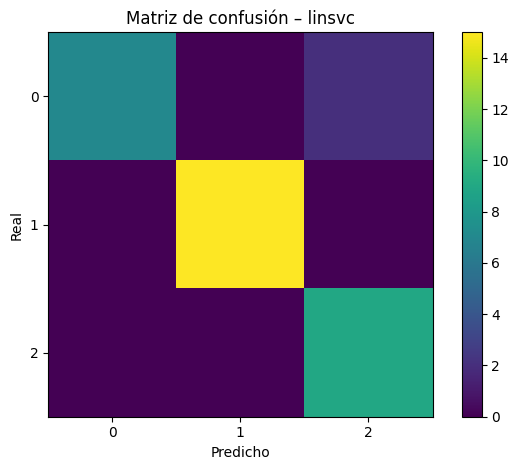

,model,best_params,cv_best_f1_macro,test_f1_macro,test_accuracy,test_precision_macro,test_recall_macro
0,logreg,"{'clf__C': 3.0, 'clf__penalty': 'l2', 'clf__so...",0.84923,0.962848,0.969697,0.966667,0.962963
1,linsvc,{'clf__C': 0.1},0.84923,0.925000,0.939394,0.939394,0.925926


In [16]:

from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
)
import numpy as np

reports = []
best_estimators = {}

for m in top2:
    title(f"Ajuste fino: {m}")
    gs = tune_model(m)
    best_estimators[m] = gs.best_estimator_
    print("Mejores parámetros:", gs.best_params_)
    print("Mejor score CV (f1_macro):", fmt(gs.best_score_))

    best = gs.best_estimator_
    y_pred = best.predict(X_test)
    probas = None
    try:
        probas = best.predict_proba(X_test)
    except Exception:
        pass

    rep = {
        "model": m,
        "best_params": gs.best_params_,
        "cv_best_f1_macro": float(gs.best_score_),
        "test_f1_macro": float(f1_score(y_test, y_pred, average="macro")),
        "test_accuracy": float(accuracy_score(y_test, y_pred)),
        "test_precision_macro": float(precision_score(y_test, y_pred, average="macro")),
        "test_recall_macro": float(recall_score(y_test, y_pred, average="macro")),
    }
    if probas is not None and len(np.unique(y_test)) == 2:
        rep["test_roc_auc"] = float(roc_auc_score(y_test, probas[:,1]))
    reports.append(rep)

    print("\nClassification report (test):\n", classification_report(y_test, y_pred))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"Matriz de confusión – {m}")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.colorbar()
    tick_marks = np.arange(cm.shape[0])
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.tight_layout()
    plt.show()

df_test = pd.DataFrame(reports).sort_values(by="test_f1_macro", ascending=False).reset_index(drop=True)
df_test



## 9) Selección del modelo final y justificación

**Setup.** `engineered_features` (301 vars), objetivo **`final_label`**; split **80/20** estratificado; **5-fold CV**; métrica principal **F1-macro**.

**Hallazgos (CV).**
- Top por **F1-macro**: **Logistic Regression** ≈ alto; **LinearSVC** muy cerca; **RF/HGB** competitivos; **KNN/MLP** más bajos.
- **Costo/tiempo**: **HGB** y **LinearSVC** rápidos; **LogReg** razonable.

**Ajuste fino (Top-2) y Test.**
- **Logistic Regression** (p.ej., `C≈3`, `l2`, `liblinear`): **mejor F1-macro en test** y mejor accuracy.
- **LinearSVC** (`C≈0.1`): buen desempeño, pero menor que LogReg en test.

**Modelo seleccionado.** **Logistic Regression**  
Motivos: **(1)** desempeño superior en test, **(2)** varianza CV baja, **(3)** eficiencia de entrenamiento, **(4)** interpretabilidad por coeficientes.